# Programming Assignment 2
## Part 2: xGBoost

## Instructions

1. **Objective**:  
   Implement an xGBoost classifier for Classification Task in this notebook.

2. **File Naming and Submission**:  
   - Save the completed notebook as `<Roll_No>_P2.ipynb`, replacing `<Roll_No>` with your roll number.  
   - Ensure all code, outputs, and results are included in the submitted file.

3. **Code Placement**:  
   - Write your code **only** in the cells marked as `## CODE REQUIRED ##`.  
   - Place your implementation between the following comments:  
     ```python
     ## START CODE HERE ##
     # Your code along with comments goes here
     ### END CODE HERE ###
     ```
   - Do not modify any other sections of the notebook.
  

4. **Execution and Output**:  
   - Run all cells to ensure the code executes correctly without errors.  
   - Save the notebook **with all outputs visible** before submission.

**NOTE:** Set random seed to `42` wherever randomization is used.


### Problem Statement  
The Telco customer churn data contains information about a fictional telco company that provided home phone and Internet services to 7043 customers in California in Q3. It indicates which customers have left, stayed, or signed up for their service. Implement an xGBoost classifier to predict whether a customer will leave or stay with the company.

### Dataset Description

1. CustomerID: A unique ID that identifies each customer.

2. Count: A value used in reporting/dashboarding to sum up the number of customers in a filtered set.

3. Country: The country of the customer’s primary residence.

4. State: The state of the customer’s primary residence.

5. City: The city of the customer’s primary residence.

6. Zip Code: The zip code of the customer’s primary residence.

7. Lat Long: The combined latitude and longitude of the customer’s primary residence.

8. Latitude: The latitude of the customer’s primary residence.

9. Longitude: The longitude of the customer’s primary residence.

10. Gender: The customer’s gender: Male, Female

11. Senior Citizen: Indicates if the customer is 65 or older: Yes, No

12. Partner: Indicate if the customer has a partner: Yes, No

13. Dependents: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc.

14. Tenure Months: Indicates the total amount of months that the customer has been with the company by the end of the quarter specified above.

15. Phone Service: Indicates if the customer subscribes to home phone service with the company: Yes, No

16. Multiple Lines: Indicates if the customer subscribes to multiple telephone lines with the company: Yes, No

17. Internet Service: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.

18. Online Security: Indicates if the customer subscribes to an additional online security service provided by the company: Yes, No

19. Online Backup: Indicates if the customer subscribes to an additional online backup service provided by the company: Yes, No

20. Device Protection: Indicates if the customer subscribes to an additional device protection plan for their Internet equipment provided by the company: Yes, No

21. Tech Support: Indicates if the customer subscribes to an additional technical support plan from the company with reduced wait times: Yes, No

22. Streaming TV: Indicates if the customer uses their Internet service to stream television programing from a third party provider: Yes, No. The company does not charge an additional fee for this service.

23. Streaming Movies: Indicates if the customer uses their Internet service to stream movies from a third party provider: Yes, No. The company does not charge an additional fee for this service.

24. Contract: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.

25. Paperless Billing: Indicates if the customer has chosen paperless billing: Yes, No

26. Payment Method: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check

27. Monthly Charge: Indicates the customer’s current total monthly charge for all their services from the company.

28. Total Charges: Indicates the customer’s total charges, calculated to the end of the quarter specified above.

29. Churn Label: Yes = the customer left the company this quarter. No = the customer remained with the company. Directly related to Churn Value.

30. Churn Value: **Target Variable**. 1 = the customer left the company this quarter. 0 = the customer remained with the company. Directly related to Churn Label.

31. Churn Score: A value from 0-100 that is calculated using the predictive tool IBM SPSS Modeler. The model incorporates multiple factors known to cause churn. The higher the score, the more likely the customer will churn.

32. CLTV: Customer Lifetime Value. A predicted CLTV is calculated using corporate formulas and existing data. The higher the value, the more valuable the customer. High value customers should be monitored for churn.

33. Churn Reason: A customer’s specific reason for leaving the company. Directly related to Churn Category.

Reference:
https://www.kaggle.com/datasets/yeanzc/telco-customer-churn-ibm-dataset

https://community.ibm.com/community/user/businessanalytics/blogs/steven-macko/2019/07/11/telco-customer-churn-1113


### Import Modules
**NOTE:** To draw the tree, you will also need to install `graphviz`, you can do that with the following command: `conda install graphviz python-graphviz`.

In [2]:
!pip install scikit-learn==1.2.0
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Load Dataset
Load in the dataset from the given file.

In [3]:
## CODE REQUIRED ##
### START CODE ###
filepath = "./dataset/Telco_customer_churn.xlsx"
df = pd.read_excel(filepath)
### END CODE ###

The four variables `"Churn Label", "Churn Score", "CLTV", "Churn Reason"` contain exit interview information and should not be used for prediciton, so we will remove them.

In [4]:
## CODE REQUIRED ##
### START CODE ###
drop_cols = ["Churn Label", "Churn Score", "CLTV", "Churn Reason"]
df.drop(columns = drop_cols, inplace = True)
### END CODE ###

Some variables only contain a single value, and will not be useful for classification, so we can remove them.

In [5]:
## CODE REQUIRED ##
### START CODE ###
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(columns = col, axis = 1, inplace = True)
### END CODE ###

We don't need 'CustomerID' because it's unique for every customer and useless for classification, or 'Lat Long', since we have separate columns for 'Latitiude' and 'Longitude'.

In [6]:
## CODE REQUIRED ##
### START CODE ###
drop_cols = ["CustomerID", "Lat Long"]
df.drop(columns = drop_cols, axis = 1, inplace = True)
### END CODE ###

Remove the whitespace from the column names, and replace it with an underscore `_`. This will be required for drawing the tree.

In [7]:
## CODE REQUIRED ##
### START CODE ###
df.columns = df.columns.str.replace(' ', '_')
### END CODE ###

Remove whitspace from city names, and replace it with an underscore `_`. We will remove whitespaces from all the values once we have identified missing values.

In [8]:
## CODE REQUIRED ##
### START CODE ###
df['City'] = df['City'].str.replace(' ', '_')
### END CODE ###

### Missing Data

Identify the rows that are missing data. xGBoost determines default behaviour for missing data, so you can just set them to 0, however if there are a lot of missing values you may need to impute artificial values instead.

`Total_Charges` contains numbers, but it is of `object` datatype, so it may contain missing values. Try converting it to numeric values using `pd.to_numeric` to see what happens.

The blank spaces `" "` are an issue. See how many rows are missing data.

In [9]:
## CODE REQUIRED ##
### START CODE ###
# df['Total_Charges'] = pd.to_numeric(df['Total_Charges'], axis=1, errors='coerce') => This gives error as we cannot convert empty cells to numeric
df[df["Total_Charges"] == ' ']
### END CODE ###

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


It is a very small number, so we can simply set the `Total_Charges` for these rows to `0` since these customers have just signed up and have `Tenure_Months` as `0` too.

In [10]:
## CODE REQUIRED ##
### START CODE ###
df.loc[df['Total_Charges'] == ' ', 'Total_Charges'] = 0
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])
### END CODE ###

Verify by checking if the customers with `Tenure_Months` as `0` have `Total_Charges` as `0` now.

In [11]:
## CODE REQUIRED ##
### START CODE ###
df[df['Tenure_Months'] == 0]
### END CODE ###

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0.0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0.0,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0.0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0.0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0.0,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0.0,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0.0,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0.0,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0.0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0.0,0


Now, we can convert the column to float.

In [12]:
## CODE REQUIRED ##
### START CODE ###
df['Total_Charges'] = df['Total_Charges'].astype(float)
### END CODE ###

We have dealt with missing values in the rows, so now we can replace all whitespaces with underscores. **Hint**: use `regex`.

In [13]:
## CODE REQUIRED ##
### START CODE ###
df = df.replace(r'^\s*$', '_', regex=True)
### END CODE ###

### Feature-Label Split
Split the data into two parts:
1. Features: the columns that we will use to make classifications.
2. Label: the column that we want to predict, i.e., `Churn_Value`.

In [14]:
## CODE REQUIRED ##
### START CODE ###
X = df.drop('Churn_Value', axis=1)
y = df['Churn_Value']
### END CODE ###

### One-Hot Encoding

We are going to use one-hot encoding to deal with categorical variables. You can use sklearn's ColumnTransformer() or pandas's get_dummies(), or explore other options. We have used get_dummies() here.

In [15]:
## CODE REQUIRED ##
### START CODE ###
X = pd.get_dummies(X)
### END CODE ###

### Train-Test Split
There is a significant class imbalance in the dataset. Verify this by dividing the number of people who left the company (`y=1`), by the total number of people in the dataset.

In [16]:
## CODE REQUIRED ##
### START CODE ###
y.value_counts() / len(y)
### END CODE ###

,count
Churn_Value,
0,0.73463
1,0.26537


So, when splitting the data into training and testing, you must use `stratify` to maintain the proportion of people who left the company in both sets. Use a `75-25` split for train and test sets.

In [17]:
## CODE REQUIRED ##
### START CODE ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)
### END CODE ###

Verify that the stratification worked as expected.

In [18]:
## CODE REQUIRED ##
### START CODE ###
print("Train", y_train.value_counts() / len(y_train))
print("Test", y_test.value_counts() / len(y_test))
### END CODE ###

Train Churn_Value
0    0.73457
1    0.26543
Name: count, dtype: float64
Test Churn_Value
0    0.73481
1    0.26519
Name: count, dtype: float64


### xGBoost Model
Build the preliminary xGBoost classifier. Use `binary:logistic` as the objective function and `auc` as the evaluation metric. Use `early_stopping_rounds` to stop building trees when the objective function doesn't improve.

In [19]:
## CODE REQUIRED ##
### START CODE ###
xgb_clf = xgb.XGBClassifier(objective = "binary:logistic", early_stopping_rounds = 5, seed = 42, eval_metric = 'auc')
xgb_clf.fit(X_train, y_train, verbose = True, eval_set = [(X_train, y_train)])
### END CODE ###

[0]	validation_0-auc:0.87455
[1]	validation_0-auc:0.88686
[2]	validation_0-auc:0.89298
[3]	validation_0-auc:0.89741
[4]	validation_0-auc:0.90236
[5]	validation_0-auc:0.90657
[6]	validation_0-auc:0.91067
[7]	validation_0-auc:0.91463
[8]	validation_0-auc:0.91733
[9]	validation_0-auc:0.91985
[10]	validation_0-auc:0.92408
[11]	validation_0-auc:0.92626
[12]	validation_0-auc:0.92944
[13]	validation_0-auc:0.93209
[14]	validation_0-auc:0.93434
[15]	validation_0-auc:0.93489
[16]	validation_0-auc:0.93654
[17]	validation_0-auc:0.93874
[18]	validation_0-auc:0.94012
[19]	validation_0-auc:0.94413
[20]	validation_0-auc:0.94460
[21]	validation_0-auc:0.94562
[22]	validation_0-auc:0.94581
[23]	validation_0-auc:0.94597
[24]	validation_0-auc:0.94634
[25]	validation_0-auc:0.94651
[26]	validation_0-auc:0.94696
[27]	validation_0-auc:0.94787
[28]	validation_0-auc:0.94874
[29]	validation_0-auc:0.94924
[30]	validation_0-auc:0.94929
[31]	validation_0-auc:0.95128
[32]	validation_0-auc:0.95146
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=5,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Plot the AUC curve for both training and test datasets.

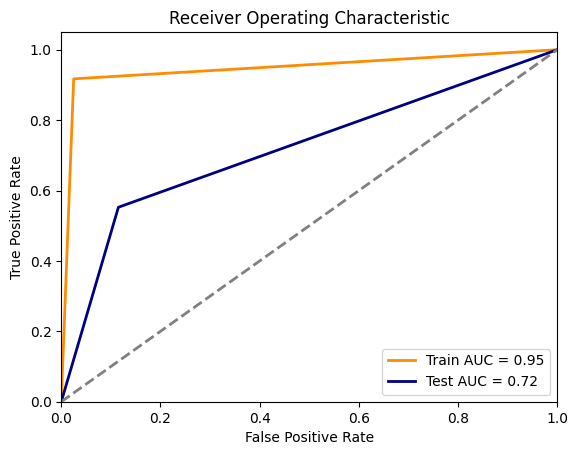

In [20]:
## CODE REQUIRED ##
### START CODE ###
y_pred_train = xgb_clf.predict(X_train)
y_pred_test = xgb_clf.predict(X_test)
fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_train)
fpr_test, tpr_test, _ = roc_curve(y_test, y_pred_test)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)
y_pred_train = xgb_clf.predict(X_train)
y_pred_test = xgb_clf.predict(X_test)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)
plt.plot(fpr_train, tpr_train, color = 'darkorange', lw = 2, label = 'Train AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color = 'navy', lw = 2, label = 'Test AUC = %0.2f' % roc_auc_test)
plt.plot([0, 1], [0, 1], color = 'gray', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
### END CODE ###

Draw a confusion matrix for the test dataset.

Accuracy: 0.7967064168086314


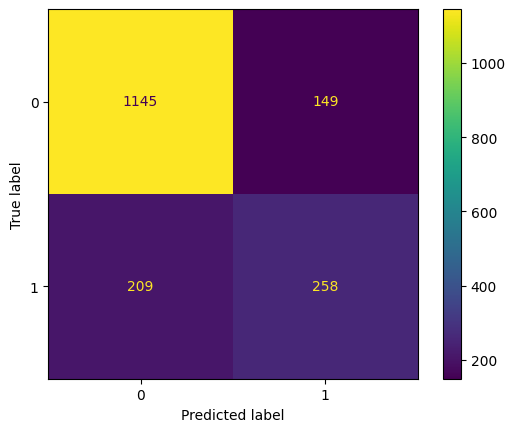

In [21]:
## CODE REQUIRED ##
### START CODE ###
print("Accuracy:", xgb_clf.score(X_test, y_test))
y_pred = xgb_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = xgb_clf.classes_)
disp.plot()
# Print accuracy
### END CODE ###

Plot the AUC-ROC curve (FPR vs. TPR).

Text(0.5, 1.0, 'Receiver Operating Characteristic')

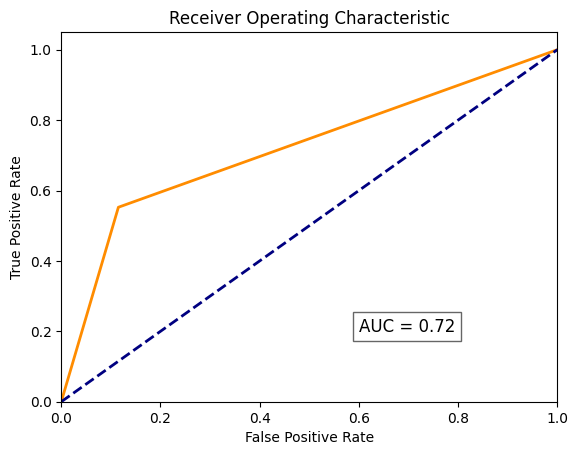

In [22]:
## CODE REQUIRED ##
### START CODE ###
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.text(0.6, 0.2, f'AUC = {roc_auc:.2f}', fontsize=12, color='black', bbox=dict(facecolor='white', alpha=0.6))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
### END CODE ###

Print the classification report.

In [23]:
## CODE REQUIRED ##
### START CODE ###
print(classification_report(y_test, y_pred))
### END CODE ###

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1294
           1       0.63      0.55      0.59       467

    accuracy                           0.80      1761
   macro avg       0.74      0.72      0.73      1761
weighted avg       0.79      0.80      0.79      1761



### Hyperparamter Tuning
xGBoost has a lot of hyperparameters:
- `max_depth` - the maximum tree depth
- `learning_rate`
- `gamma` - minimum loss reduction required to make a further partition on a leaf node of the tree
- `reg_lambda` - L2 regularisation parameter
- `scale_pos_weight` - scales the gradient for the positive class to help with imbalanced data
- `colsample_bytree` - subsample ratio of columns when constructing each tree
- `subsample` - ratio of the training instances, prevents overfitting

Each student will tune a specific hyperparameter, determined by the remainder when dividing their roll number by **7**. Follow the instructions below carefully to ensure you are using the correct hyperparameters.

### Steps to Select Hyperparameters:

1. **Identify Your Roll Number**:  
   Use the last five digits of your roll number to determine the corresponding set of hyperparameters.  
   For example, if your roll number is **20CS30067**, you will use the last five digits (30067), and calculate the remainder when divided by **7**.

2. **Calculate the Remainder**:  
   Take the last five digits of your roll number and find the remainder when divided by **7**. This will determine which hyperparameter set you should use:
   - **If the remainder is 0**, use `max_depth`.
   - **If the remainder is 1**, use `learning_rate`.
   - **If the remainder is 2**, use `gamma`.
   - **If the remainder is 3**, use `reg_lambda`.
   - **If the remainder is 4**, use `scale_pos_weight`.
   - **If the remainder is 5**, use `colsample_bytree`.
   - **If the remainder is 6**, use `subsample`.

You are welcome to use `RandomizedSearchCV` or `GridSearchCV` to find the best hyperparameter value for your model.

Find the optimal hyperparameter value and report your findings.

- Train an xGBoost model with the optimal value of the given hyperparameter.
- Plot the AUC curve for both training and test datasets.
- Draw the confusion matrix for the test dataset.
- Plot the AUC-ROC curve.
- Print the classification report.

Are you able to improve your model? Does it classify customers who leave the company (`Churn_Value=1`) better?

In [24]:
## CODE REQUIRED ##
### START CODE ###
param_grid = {'subsample': [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]}
random_search = RandomizedSearchCV(estimator = xgb_clf, param_distributions = param_grid, n_iter = 7, scoring = 'roc_auc', cv = 5, random_state = 42, n_jobs = 2)
random_search.fit(X_train, y_train, **{'eval_set': [(X_test, y_test)]})
best_subsample = random_search.best_params_['subsample']
print("Best subsample:", best_subsample)
### END CODE ###

[0]	validation_0-auc:0.85186
[1]	validation_0-auc:0.85689
[2]	validation_0-auc:0.85640
[3]	validation_0-auc:0.85922
[4]	validation_0-auc:0.85974
[5]	validation_0-auc:0.86084
[6]	validation_0-auc:0.85967
[7]	validation_0-auc:0.85820
[8]	validation_0-auc:0.85782
[9]	validation_0-auc:0.85703
Best subsample: 0.85


In [25]:
## CODE REQUIRED ##
### START CODE ###
xgb_clf_tuned = xgb.XGBClassifier(objective = "binary:logistic", eval_metric = "auc", early_stopping_rounds = 10, subsample = best_subsample)
xgb_clf_tuned.fit(X_train, y_train, eval_set = [(X_train, y_train)])
### END CODE ###

[0]	validation_0-auc:0.86963
[1]	validation_0-auc:0.88182
[2]	validation_0-auc:0.88923
[3]	validation_0-auc:0.89400
[4]	validation_0-auc:0.89933
[5]	validation_0-auc:0.90312
[6]	validation_0-auc:0.90796
[7]	validation_0-auc:0.91123
[8]	validation_0-auc:0.91500
[9]	validation_0-auc:0.91847
[10]	validation_0-auc:0.92278
[11]	validation_0-auc:0.92451
[12]	validation_0-auc:0.92789
[13]	validation_0-auc:0.93099
[14]	validation_0-auc:0.93207
[15]	validation_0-auc:0.93256
[16]	validation_0-auc:0.93501
[17]	validation_0-auc:0.93767
[18]	validation_0-auc:0.94020
[19]	validation_0-auc:0.94159
[20]	validation_0-auc:0.94190
[21]	validation_0-auc:0.94390
[22]	validation_0-auc:0.94539
[23]	validation_0-auc:0.94636
[24]	validation_0-auc:0.94641
[25]	validation_0-auc:0.94702
[26]	validation_0-auc:0.94835
[27]	validation_0-auc:0.95030
[28]	validation_0-auc:0.95164
[29]	validation_0-auc:0.95213
[30]	validation_0-auc:0.95257
[31]	validation_0-auc:0.95379
[32]	validation_0-auc:0.95442
[33]	validation_0-au

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [26]:
## CODE REQUIRED ##
### START CODE ###
y_pred_train = xgb_clf_tuned.predict(X_train)
y_pred_test = xgb_clf_tuned.predict(X_test)

from sklearn.metrics import roc_curve, auc
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_pred_train)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_pred_test)
roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)
### END CODE ###

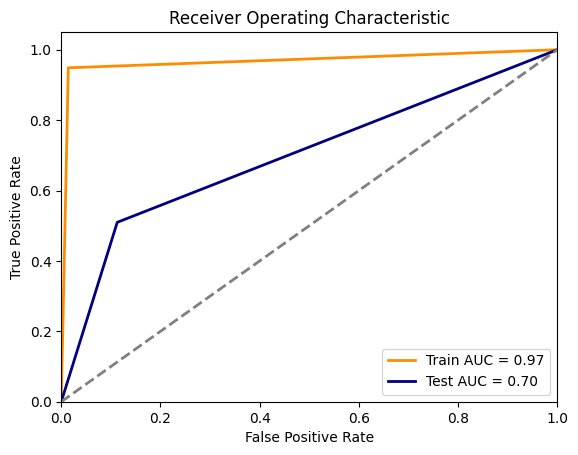

In [27]:
## CODE REQUIRED ##
### START CODE ###
import matplotlib.pyplot as plt
plt.plot(fpr_train, tpr_train, color = 'darkorange', lw = 2, label = 'Train AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_test, tpr_test, color = 'navy', lw = 2, label = 'Test AUC = %0.2f' % roc_auc_test)
plt.plot([0, 1], [0, 1], color = 'gray', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")
plt.show()
### END CODE ###

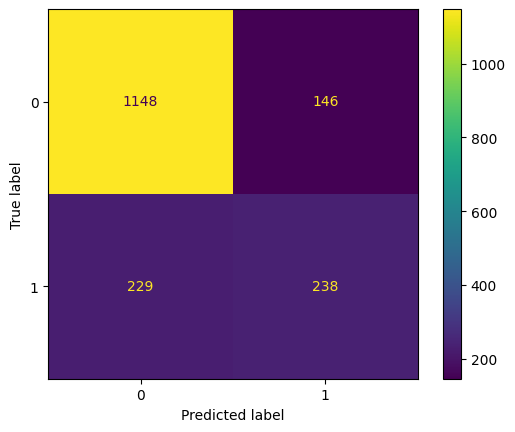

Accuracy:  0.787052810902896


In [28]:
## CODE REQUIRED ##
### START CODE ###
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = xgb_clf_tuned.classes_)
disp.plot()
plt.show()
accuracy=(cm[0][0] + cm[1][1]) / cm.sum()
print("Accuracy: ", accuracy)
### END CODE ###

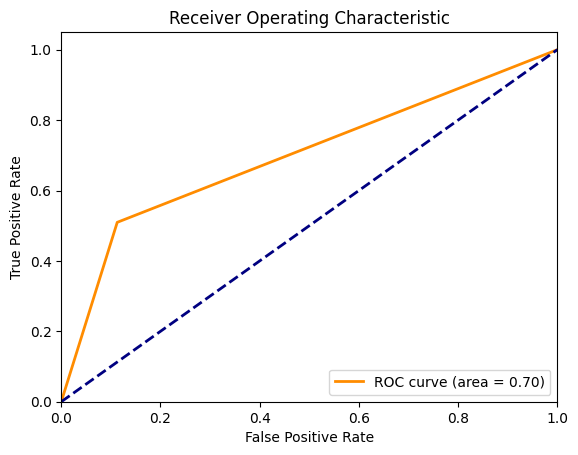

In [29]:
## CODE REQUIRED ##
### START CODE ###
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc = "lower right")
plt.show()
### END CODE ###

### Visualising an xGBoost Tree (Optional)
To get the necessary information, we will only build the first tree, otherwise, we'll get the average over all the trees.
- `weight`: number of times a feature is used in a branch or root across all trees
- `gain`: average gain across all splits that the feature is used in
- `cover`: average coverage across all splits a feature is used in
- `total_gain`: total gain across all splits a feature is used in
- `total_cover`: total coverage across all splits a feature is used in

Build an xGBoost model with `n_estimators=1` and the optimal hyperparameters according to your experiments.

In [30]:
## CODE REQUIRED ##
### START CODE ###
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_test))
### END CODE ###

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1294
           1       0.62      0.51      0.56       467

    accuracy                           0.79      1761
   macro avg       0.73      0.70      0.71      1761
weighted avg       0.78      0.79      0.78      1761



weight:  {'Zip_Code': 321.0, 'Latitude': 262.0, 'Longitude': 276.0, 'Tenure_Months': 225.0, 'Monthly_Charges': 312.0, 'Total_Charges': 264.0, 'City_Anaheim': 1.0, 'City_Apple_Valley': 8.0, 'City_Arcadia': 2.0, 'City_Bakersfield': 4.0, 'City_Berkeley': 2.0, 'City_Beverly_Hills': 4.0, 'City_Burbank': 2.0, 'City_Compton': 2.0, 'City_Corona': 4.0, 'City_Covina': 2.0, 'City_Daly_City': 2.0, 'City_Desert_Hot_Springs': 2.0, 'City_El_Cajon': 3.0, 'City_El_Monte': 2.0, 'City_Fremont': 3.0, 'City_Fullerton': 2.0, 'City_Glendale': 5.0, 'City_Guatay': 1.0, 'City_Hayward': 3.0, 'City_Indian_Wells': 1.0, 'City_Irvine': 4.0, 'City_La_Mesa': 3.0, 'City_La_Puente': 5.0, 'City_Lakewood': 3.0, 'City_Lancaster': 4.0, 'City_Long_Beach': 2.0, 'City_North_Hollywood': 8.0, 'City_Oakland': 5.0, 'City_Ontario': 3.0, 'City_Palm_Desert': 3.0, 'City_Pomona': 2.0, 'City_Rancho_Cordova': 2.0, 'City_Riverside': 3.0, 'City_Sacramento': 1.0, 'City_San_Bernardino': 3.0, 'City_San_Diego': 6.0, 'City_San_Francisco': 1.0, 

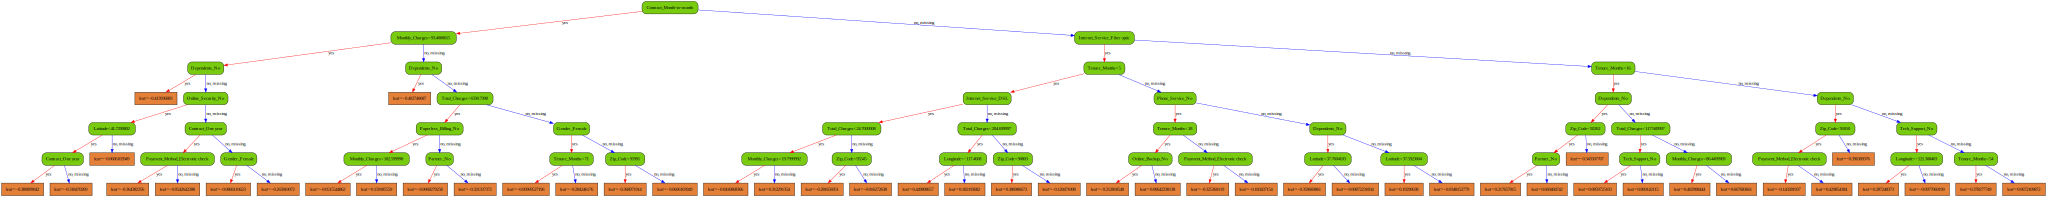

In [31]:
## CODE REQUIRED ##
### START CODE ###
bst = xgb_clf.get_booster() # Replace clf_xgb with your model variable name
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'}

leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

xgb.to_graphviz(xgb_clf, num_trees=0, size="10,10", condition_node_params=node_params, leaf_node_params=leaf_params)
### END CODE ###